## Классификация MNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

Давайте обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В этом задании мы воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплайн обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку с первого занятия.

Мы настоятельно рекомендуем писать код «с нуля», лишь изредка подглядывая в готовые примеры, а не просто «копировать-вставлять». Это поможет вам в будущем.

In [30]:
# global_mean = 0
# for imgs, labels in train_data_loader:
#   global_mean += imgs.sum()

# global_mean /= len(train_mnist_data) * 28 * 28

# global_var = 0
# for imgs, labels in train_data_loader:
#   global_var += ((imgs - global_mean) ** 2).sum()

# global_var /= len(train_mnist_data) * 28 * 28
# global_std = torch.sqrt(global_var)

In [29]:
print(global_mean, global_std)

tensor(0.1307) tensor(0.3081)


Text(0.5, 1.0, 'Image label: 0')

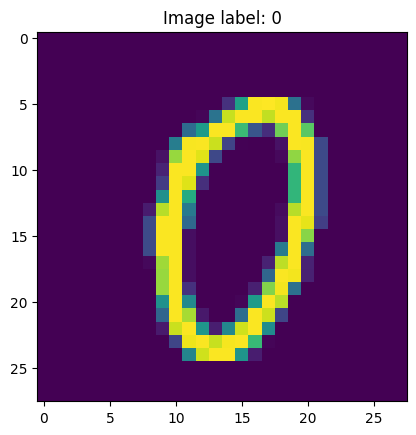

In [32]:
# do not change the code in the block below
# __________start of block__________

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.1307], std=[0.3081])
])

train_mnist_data = MNIST('.', train=True, transform=transform, download=True)
test_mnist_data = MNIST('.', train=False, transform=transform, download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель, представленную ниже. Пожалуйста, не создавайте чрезмерно сложную сеть — она не должна быть глубже четырёх слоёв (можно и меньше). Ваша основная задача — обучить модель и добиться как минимум 92% точности на тестовой выборке (hold-out выборке).

*Примечание: линейных слоёв и функций активации должно быть достаточно.*

__Обратите внимание, ваша модель должна быть представлена переменной `model`__

In [44]:
fl = nn.Flatten()
out = fl(torch.randn(32, 1, 28, 28))
out.size()

torch.Size([32, 784])

In [51]:
# На MNIST с таким порогом по тесту хватит и многослойного перцептрона

class MyModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.flatten = nn.Flatten()  # out.size() = [32, 784]
    self.linear1 = nn.Linear(in_features=784, out_features=30)
    self.linear2 = nn.Linear(in_features=30, out_features=20)
    self.linear3 = nn.Linear(in_features=20, out_features=10)
    self.act = nn.ReLU()

  def forward(self, img):
    img = self.flatten(img)
    img = self.act(self.linear1(img))
    img = self.act(self.linear2(img))
    img = self.linear3(img) # Без активации, потому что будем использовать nn.CrossEntropyLoss()

    return img

In [52]:
# Creating model instance
model = MyModel()

Ниже доступны локальные тесты для проверки вашей модели:

In [60]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Обучите модель на обучающей выборке. Рекомендуем поэкспериментировать с различными оптимизаторами.


In [64]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = 'cpu'
model.to(device)

MyModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=10, bias=True)
  (act): ReLU()
)

In [65]:
def train_one_epoch():
  model.train()

  cur_loss = 0

  for imgs, labels in train_data_loader:
    imgs, labels = imgs.to(device), labels.to(device)

    optimizer.zero_grad()

    outs = model(imgs)
    loss = loss_fn(outs, labels)
    loss.backward()

    optimizer.step()
    cur_loss += loss.item()

  return cur_loss / len(train_data_loader)

In [66]:
n_epochs = 10

for epoch in range(n_epochs):

  print('EPOCH {}:'.format(epoch + 1))
  cur_train_loss = train_one_epoch()

  model.eval()

  cur_val_loss = 0

  with torch.no_grad():

    for imgs, labels in test_data_loader:

        imgs, labels = imgs.to(device), labels.to(device)

        val_out = model(imgs)
        cur_val_loss += loss_fn(val_out, labels).item()

  cur_val_loss /= len(test_data_loader)

  print('LOSS train {} valid {}'.format(cur_train_loss, cur_val_loss))

EPOCH 1:
LOSS train 0.3583256425033013 valid 0.19998566892009956
EPOCH 2:
LOSS train 0.18438008577624956 valid 0.15207815938703598
EPOCH 3:
LOSS train 0.14313833460633954 valid 0.13177334645260186
EPOCH 4:
LOSS train 0.11861027745728692 valid 0.12484493156368383
EPOCH 5:
LOSS train 0.10687181552536786 valid 0.1201267162953078
EPOCH 6:
LOSS train 0.09631173171152671 valid 0.11242945076129325
EPOCH 7:
LOSS train 0.08532620428732286 valid 0.11889508089084869
EPOCH 8:
LOSS train 0.08006576600372792 valid 0.11855018414748898
EPOCH 9:
LOSS train 0.07521201438335702 valid 0.11865525982712177
EPOCH 10:
LOSS train 0.06907916121541832 valid 0.11430472700334803


Также помните, что вы всегда можете обратиться к отличной [документации](https://pytorch.org/docs/stable/index.html) и [учебным материалам](https://pytorch.org/tutorials/).

Оценим качество классификации:

In [67]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [68]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.98018


In [69]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [70]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9678


Проверка, что пороги пройдены:

In [71]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model`, а файл `hw_mnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
file_path = '/content/drive/My Drive/ml_training_3_data/hw_mnist_data_dict.npy'

In [75]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists(file_path), 'Please, download `hw_mnist_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load(file_path, allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_mnist_task_1.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_mnist_task_1.json`')
# __________end of block__________

File saved to `submission_dict_mnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_mnist_task_1.json` в задачу Warmup (hw_mnist)

На этом задание завершено. Поздравляем!